<a href="https://colab.research.google.com/github/ChrLawSSE/6123/blob/main/Part2_Group_Assignment_6123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2

# Data Cleaning



In [6]:
# We import the relevant libraries for the exercise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Load the dataset in CSV from GitHub
url = "https://raw.githubusercontent.com/ChrLawSSE/6123/refs/heads/main/Loan_Portfolio.csv"
df = pd.read_csv(url, header=1)

# Print columns to verify that we have located the correct header row
print(df.columns)

Index(['Portfolio 1', 'Portfolio 2', 'Portfolio 3', 'Portfolio 4',
       'Portfolio 5', 'Loan Number', 'Loan Amount (USD)', 'Industry',
       'Lending Region', 'Country', 'Loan Additionality ',
       'Climate Change Hotspot', 'Biodiversity Hotspot',
       'Soil Degradation Hotspot', 'Water Scarcity Hotspot', 'Certification',
       'Planting & maintaining trees for biodiversity conservation and carbon capture',
       'Clean & appropriate tech for reduced emissions and resource efficiency',
       'Poverty Level', 'Gender Inclusion', 'Livelihood Improvement',
       'Farmers & Employees', 'Female \nFarmers & Employees',
       'Probability of Default', 'Expected Revenue',
       'Expected Operating Expenses', 'Expected Cost of Debt',
       'Expected Cost of Risk', 'Expected Net Loan Income', 'Unnamed: 29',
       'Unnamed: 30'],
      dtype='object')


In [7]:
#Cropping the dataframe to remove superfluous rows

df = df.iloc[:200]  # We keep the first 200 rows of the df, since we have 200 loans to pick from for our portfolios
start_col = df.columns.get_loc("Loan Number")
# Removing the columns before "Loan Number", since we don't need them
df = df.iloc[:, start_col:]

# Checking to see if everything has gone smoothly
display(df.head())
print(df.info())

,Loan Number,Loan Amount (USD),Industry,Lending Region,Country,Loan Additionality,Climate Change Hotspot,Biodiversity Hotspot,Soil Degradation Hotspot,Water Scarcity Hotspot,...,Farmers & Employees,Female \nFarmers & Employees,Probability of Default,Expected Revenue,Expected Operating Expenses,Expected Cost of Debt,Expected Cost of Risk,Expected Net Loan Income,Unnamed: 29,Unnamed: 30
0,46.0,717’500,Coffee,Central America,Honduras,Low,Yes,Yes,Yes,No,...,1’555,354,3.20%,90’952,-16’267,-18’618,-28’019,28’047,NaN,h
1,177.0,820’000,Coffee,East Africa,"Tanzania, United Republic Of",Medium,No,No,No,No,...,5’003,2’501,1.52%,72’841,-19’215,-20’556,-6’147,26’923,NaN,NaN
2,126.0,738’000,Coffee,Central America,Guatemala,Medium,No,Yes,No,No,...,1’106,221,1.61%,61’674,-11’847,-16’000,-12’870,20’957,NaN,NaN
3,171.0,738’000,Coffee,East Africa,"Congo, The Democratic Republic Of The",Medium,No,Yes,No,No,...,6’033,1’373,3.22%,89’537,-31’063,-19’400,-21’044,18’030,NaN,NaN
4,113.0,410’000,Coffee,Central America,Nicaragua,Low,Yes,Yes,No,No,...,244,31,1.99%,47’394,-13’320,-9’528,-9’729,14’817,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 26 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Loan Number                                                                    200 non-null    float64
 1   Loan Amount (USD)                                                              200 non-null    object 
 2   Industry                                                                       200 non-null    object 
 3   Lending Region                                                                 200 non-null    object 
 4   Country                                                                        200 non-null    object 
 5   Loan Additionality                                                             200 non-null    object 
 6   Climate Change Hotspot    

In [8]:
# Converting the data in our columns into numerical data

columns_to_convert = [
    "Loan Amount (USD)",
    "Farmers & Employees",
    "Female \nFarmers & Employees",
    "Probability of Default",
    "Expected Revenue",
    "Expected Operating Expenses",
    "Expected Cost of Debt",
    "Expected Cost of Risk",
    "Expected Net Loan Income"
]

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace("’", ''), errors='coerce')

# Verifying that the operation was successful
print(df[columns_to_convert].dtypes)

Loan Amount (USD)                 int64
Farmers & Employees               int64
Female \nFarmers & Employees      int64
Probability of Default          float64
Expected Revenue                  int64
Expected Operating Expenses       int64
Expected Cost of Debt             int64
Expected Cost of Risk             int64
Expected Net Loan Income          int64
dtype: object


# The Efficient Impact Frontier




In [9]:
target = int(1000000)    # The number of valid portfolios required for our simulation
batch = 50           # number of candidate portfolios to generate per batch
budget = 2500000              # Setting our investment constraint
n_loans = 200


def portfolio_generator(target, batch, n_loans, budget, loan_amounts):
# This generator only generates valid portfolios per our constraints

    collected = 0
    while collected < target:
        for _ in range(batch):
            k = np.random.randint(1, 11)
            inds = np.random.choice(n_loans, size=k, replace=False)
            candidate = np.zeros(n_loans, dtype=int)
            candidate[inds] = 1
            total_allocation = loan_amounts[candidate == 1].sum()
            if 0 < total_allocation <= budget:
                collected += 1
                yield candidate, total_allocation
                if collected >= target:
                    break

loan_amounts = df["Loan Amount (USD)"].to_numpy()
expected_net_income = df["Expected Net Loan Income"].to_numpy(dtype=float)
female_reached = df["Female \nFarmers & Employees"].to_numpy(dtype=float)


# We simulate the portfolios and store only the metrics
results = []
for candidate, total_alloc in portfolio_generator(target, batch, n_loans, budget, loan_amounts):
    # Compute the metrics for the candidate portfolio
    net_income = expected_net_income[candidate == 1].sum()
    total_female = female_reached[candidate == 1].sum()
    results.append((candidate, total_alloc, net_income, total_female))

# Converting results into a df
portfolio_df_new = pd.DataFrame({
    "Total Expected Net Loan Income": [r[2] for r in results],
    "Total Female Farmers and Employees Reached": [r[3] for r in results]
})

print(portfolio_df_new.head(30))
portfolio_df_new.info()

    Total Expected Net Loan Income  Total Female Farmers and Employees Reached
0                           5242.0                                      1179.0
1                          -3824.0                                       567.0
2                        -104045.0                                     13152.0
3                         -32733.0                                       966.0
4                           7872.0                                       494.0
5                        -123977.0                                     43028.0
6                         -15920.0                                      1381.0
7                        -106460.0                                       392.0
8                        -216134.0                                      1128.0
9                         -33125.0                                       536.0
10                        -44380.0                                     13234.0
11                       -166467.0                  

In [10]:
data = {
    "Traditional": [2357500, 2887, 82573],
    "Positive": [2484600, 3642, 79961],
    "Integration": [2480500, 112352, -4984],
    "Impact": [2400550, 125428, -58731],
    "Philanthropy": [2482550, 129928, -88256],

}

df_results = pd.DataFrame(
    data,
    index=[
        "Total loans amount",
        "Total Female Farmers and Employees Reached",
        "Total Expected Net Loan Income"
    ]
)
df_results=df_results.T
display(df_results)


,Total loans amount,Total Female Farmers and Employees Reached,Total Expected Net Loan Income
Traditional,2357500,2887,82573
Positive,2484600,3642,79961
Integration,2480500,112352,-4984
Impact,2400550,125428,-58731
Philanthropy,2482550,129928,-88256


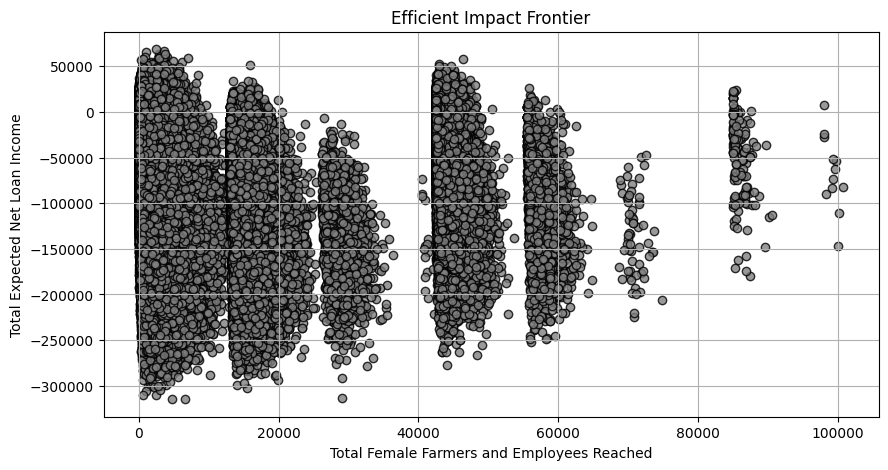

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(
    portfolio_df_new["Total Female Farmers and Employees Reached"],
    portfolio_df_new["Total Expected Net Loan Income"],
    alpha=0.8,
    edgecolor='k',
    c = 'grey'
)

plt.xlabel("Total Female Farmers and Employees Reached")
plt.ylabel("Total Expected Net Loan Income")
plt.title("Efficient Impact Frontier")
plt.grid(True)
plt.show()

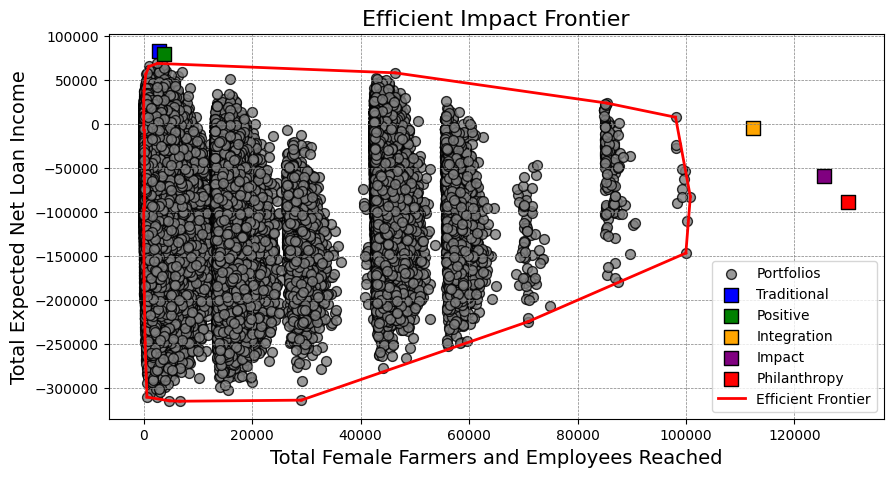

In [12]:
# Extract data
x = portfolio_df_new["Total Female Farmers and Employees Reached"].values
y = portfolio_df_new["Total Expected Net Loan Income"].values


# Stack points into an array for Convex Hull computation
points = np.column_stack((x, y))

# Compute Convex Hull
hull = ConvexHull(points)

# Plot original scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(x, y, alpha=0.8, edgecolor='k', color='grey', s=50, label="Portfolios")

# Define colors and labels for each strategy
strategy_colors = ['blue', 'green', 'orange', 'purple', 'red']
strategy_labels = ["Traditional", "Positive", "Integration", "Impact", "Philanthropy"]

# Plot the various strategies with different colors and labels
for i, (index, row) in enumerate(df_results.iterrows()):
    plt.scatter(
        row["Total Female Farmers and Employees Reached"],
        row["Total Expected Net Loan Income"],
        c=strategy_colors[i % len(strategy_colors)],
        edgecolor='k',
        marker='s',
        s=100,
        label=strategy_labels[i % len(strategy_labels)]  # Assign corresponding label
    )


# Plot efficient frontier
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-', lw=2)

# Manually add a single legend entry for the efficient frontier
plt.plot([], [], 'r-', lw=2, label="Efficient Frontier")

# Labels and title
plt.xlabel("Total Female Farmers and Employees Reached", fontsize=14)
plt.ylabel("Total Expected Net Loan Income", fontsize=14)
plt.title("Efficient Impact Frontier", fontsize=16)

# Grid
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Grid and legend
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")

# Show plot
plt.show()
